# Quickstart tutorial

The basic functionality of the catalog is demonstrated in this tutorial. If you haven't already read the [What is it](what.rst) section, you may find it helpful to do so before progressing with this tutorial. You can download the Jupyter notebook rendered below from [here](https://github.com/ACCESS-NRI/access-nri-intake-catalog/blob/main/docs/usage/quickstart.ipynb) and run it yourself in an NCI ARE instance.

In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs

## Import the catalog 

We'll start by importing the catalog and getting a feel for what it contains.

In [2]:
import intake

catalog = intake.cat.access_nri

With that, we can now use `catalog` to search and load ~3 PB of data without having to know where the data is or how it's structured. 

The catalog includes a wide variety of climate data products. The "name" column gives the name of the data product and the other columns provide additional metadata associated with each product. As we'll demonstrate below, you can search on metadata in these columns to filter for data products that may be of interest to you. Scroll through the products below and get an idea for what each product is by looking at the entry in the description column.

In [3]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, 3hr, 1mon, 3mon, fx}","{temp_surface_ave, u, tx_trans, surface_temp, tmask, strength_m, buoyfreq2_wt, hs_m, total_ocean_calving, total_ocean_runoff, bih_fric_u, frz_onset_m, sens_heat, alidr_ai_m, sw_heat, pme_net, tota..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, surface_temp, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_calving, total_ocean_runoff, bottom_temp, bih_fric_u, vorticity_z, temp_int_rhodz, sens_heat,..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, surface_temp, Tinz, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_runoff, fsurf_ai_m, fcondtop_ai_m, bottom_temp, bih_fric_u, temp_int_rhodz, sens_heat, ..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, Tinz, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_runoff, fsurf_ai_m, fcondtop_ai_m, bottom_temp, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{6hr, 3hr, 1day, 1mon, fx}","{Tinz, vvel, strength_m, pprod_gross_int100, sens_heat, total_ocean_evap_heat, HTE, salt, ty_trans_rho, alvdf_ai_m, sfc_salt_flux_restore, NCAT, dic_int100, pprod_gross, det_xflux_adv, v, aice_m, ..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx, subhr}","{temp_surface_ave, u, tx_trans, tmask, vvel, det_intmld, src01, strength_m, surface_dic, dic, buoyfreq2_wt, pprod_gross_int100, npp3d, src05, total_ocean_runoff, hs_m, fsurf_ai_m, fcondtop_ai_m, b..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{u, tx_trans, temp_int_rhodz, sens_heat, pme_net, ht, dzt, average_DT, wfimelt, salt, ty_trans_rho, sea_level, tau_y, sfc_salt_flux_restore, fprec, temp_xflux_adv_int_z, bmf_u, ekman_we, sfc_salt_..."
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, bottom_temp, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_ne..."
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total_ocea..."


## Using the catalog

Each entry (row) in the catalog describes a data product comprising many datasets spread across many files (a "dataset" here is a set of files that can be readily opened and combined for analysis using xarray - more on this later). For example, in a given ACCESS-CM2 product, there may be a dataset of ocean variables at monthly frequency, atmospheric variables at monthly frequency etc. Each entry in the catalog has a corresponding Intake-ESM datastore that can be used to filter for datasets of interest based on metadata in the datastore and then to open those datasets using xarray.

The general process for using the catalog is as follows:

1. Search the ACCESS-NRI catalog for data products that are of interest to you.
2. Open the Intake-ESM datastore(s) for the product(s) of interest. 
3. Search the Intake-ESM datastore(s) for the datasets within each product that are of interest to you.
4. Open the datasets of interest as xarray Dataset(s).
5. Perform some analysis on the xarray Dataset(s).

This process is illustrated in the schematic below. Pink text indicates the methods used to perform each task.

<img src="../_static/catalog_flow.svg" alt="Alternative text" />

## Filtering the catalog

We can search on the columns in the ACCESS-NRI catalog. For example, we could search for all products that use the model `ACCESS-OM2`. The `search` method returns another catalog object with entries that satisfy our search criteria.

In [4]:
catalog_filtered = catalog.search(model="ACCESS-OM2")
catalog_filtered

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, 3hr, 1mon, 3mon, fx}","{temp_surface_ave, u, tx_trans, surface_temp, tmask, strength_m, buoyfreq2_wt, hs_m, total_ocean_calving, total_ocean_runoff, bih_fric_u, frz_onset_m, sens_heat, alidr_ai_m, sw_heat, pme_net, tota..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, surface_temp, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_calving, total_ocean_runoff, bottom_temp, bih_fric_u, vorticity_z, temp_int_rhodz, sens_heat,..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, surface_temp, Tinz, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_runoff, fsurf_ai_m, fcondtop_ai_m, bottom_temp, bih_fric_u, temp_int_rhodz, sens_heat, ..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tx_trans, Tinz, tmask, vvel, strength_m, buoyfreq2_wt, hs_m, total_ocean_runoff, fsurf_ai_m, fcondtop_ai_m, bottom_temp, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{6hr, 3hr, 1day, 1mon, fx}","{Tinz, vvel, strength_m, pprod_gross_int100, sens_heat, total_ocean_evap_heat, HTE, salt, ty_trans_rho, alvdf_ai_m, sfc_salt_flux_restore, NCAT, dic_int100, pprod_gross, det_xflux_adv, v, aice_m, ..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx, subhr}","{temp_surface_ave, u, tx_trans, tmask, vvel, det_intmld, src01, strength_m, surface_dic, dic, buoyfreq2_wt, pprod_gross_int100, npp3d, src05, total_ocean_runoff, hs_m, fsurf_ai_m, fcondtop_ai_m, b..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{u, tx_trans, temp_int_rhodz, sens_heat, pme_net, ht, dzt, average_DT, wfimelt, salt, ty_trans_rho, sea_level, tau_y, sfc_salt_flux_restore, fprec, temp_xflux_adv_int_z, bmf_u, ekman_we, sfc_salt_..."
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, bottom_temp, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_ne..."
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total_ocea..."


We can also combine queries in a search. For example, below we search for all products that use the model `ACCESS-OM2` and contain the variable `wdet100` at daily frequency.

In [5]:
catalog.search(model="ACCESS-OM2", frequency="1day", variable="wdet100")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wdet100}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},{ocean},{1day},{wdet100}


```{note}
Note, metadata in the `realm` and `frequency` columns of the ACCESS-NRI catalog follow a standard vocabulary that is very similar to CMIP6 (but slightly more general):

 - `realm` may be one of:
   - `aerosol`,
   - `atmos`,
   - `atmosChem`,
   - `land`,
   - `landIce`,
   - `none`,
   - `ocean`,
   - `ocnBgchem`,
   - `seaIce`,
   - `unknown`
 - `frequency` may be one of (where `<int>` is an integer):
   - `fx`
   - `subhr`
   - `<int>hr`
   - `<int>day`
   - `<int>mon`
   - `<int>yr`
   - `<int>dec`
  
Some attempt has been made to use consistent model names in the `model` column (e.g. always use "ACCESS-OM2" for ACCESS-OM2), but model naming is not enforced. The variable names in the `variable` column are whatever they're called in the associated data product.
```

## Data discovery

The catalog `search` method is a powerful data-discovery tool.

For example, the ACCESS-NRI catalog includes as entries the [CMIP5 and CMIP6 Intake-ESM datastores managed by NCI](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098). These datastores contain a very large number of models and variables. It can be difficult to work out what variables are available for what models and what frequencies. The ACCESS-NRI catalog can help with this.

As an example let's look at the `cmip6_oi10` datastore, which comprises a very large number of models and variables.

In [6]:
catalog.search(name="cmip6_oi10")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{GFDL-OM4p5B, IITM-ESM, CMCC-CM2-VHR4, EC-Earth3-CC, CAS-ESM2-0, CESM2-FV2, GISS-E2-1-G, GFDL-CM4C192, CAMS-CSM1-0, IPSL-CM6A-LR, EC-Earth3-LR, GFDL-CM4, MRI-AGCM3-2-S, E3SM-1-1-ECA, GISS-E2-2-G, ...",{Replicated CMIP6-era datasets catalogued by NCI},"{land, atmosChem, seaIce, ocnBgchem, atmos, landIce, ocean, aerosol}","{6hr, 1yr, 1day, 3hr, 1mon, fx, 1hr, subhr}","{sidmassdyn, osaltpsmadvect, zfull, gpp, sfdsi, zostoga, sbl, sispeed, sfcWind, tauuo, cWood, ta, shrubFrac, friver, fNAnthDisturb, oh, htovovrt, msftmz, nLeaf, huss, fgco2nat, nMineral, uas, cLan..."


Say we are specifically interested in the variable `burntFractionAll`. Searching on this variable, we can easily see that this is only available in one model (`EC-Earth3-Veg`) at one frequency (`1mon`).

In [7]:
catalog.search(name="cmip6_oi10", variable="burntFractionAll")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,{EC-Earth3-Veg},{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},{burntFractionAll}


We can also use regex strings in our searches. For example, we could search for variables containing the substrings `"burnt"` and `"Fire"`. We can see that there are five variables, all with monthly frequency, across a large number of models that satisfy this criteria.

In [8]:
catalog.search(name="cmip6_oi10", variable=[".*burnt.*", ".*Fire.*"])

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{AWI-ESM-1-1-LR, MRI-ESM2-0, MPI-ESM-1-2-HAM, SAM0-UNICON, GFDL-ESM4, NorESM2-LM, TaiESM1, CESM2-WACCM, NorESM2-MM, CNRM-ESM2-1, CESM2-WACCM-FV2, CESM2, E3SM-1-1-ECA, MPI-ESM1-2-LR, NorCPM1, E3SM-...",{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},"{fFireNat, fFire, burntFractionAll, fFireAll, cTotFireLut}"


Or we might want to look for a particular substring in the description (although this is probably not a good idea in general as we can't always rely on descriptions to be written/formatted in a consistent way).

In [9]:
catalog.search(description=".*RYF9091.*")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, 3hr, 1mon, 3mon, fx}","{temp_surface_ave, u, tx_trans, surface_temp, tmask, strength_m, buoyfreq2_wt, hs_m, total_ocean_calving, total_ocean_runoff, bih_fric_u, frz_onset_m, sens_heat, alidr_ai_m, sw_heat, pme_net, tota..."
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total_ocea..."
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, fx, 1yr}","{temp_surface_ave, u, tx_trans, tmask, strength_m, fcondtopn_ai_m, hs_m, total_ocean_calving, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, frz_onset_m, alidr_ai_m, ht, total_ocean_evap_heat, dz..."
025deg_jra55_ryf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0\nRYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, bottom_temp, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_ne..."
1deg_era5_ryf,{ACCESS-OM2},{1 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total_ocea..."
1deg_jra55_ryf9091_gadi,{ACCESS-OM2},{1 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, fx, 1yr}","{temp_rivermix_on_nrho, temp_surface_ave, u, tx_trans, tmask, temp_vdiffuse_diff_cbt_kppicon_on_nrho, strength_m, fcondtopn_ai_m, hs_m, total_ocean_calving, total_ocean_runoff, fcondtop_ai_m, fswa..."
1deg_jra55v14_ryf,{ACCESS-OM2},{1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 RYF9091\nrepeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx}","{temp_surface_ave, u, tmask, vvel, strength_m, temp_yflux_gm_int_z, fcondtopn_ai_m, hs_m, total_ocean_runoff, fcondtop_ai_m, fswabs_ai_m, temp_int_rhodz, sens_heat, alidr_ai_m, pme_net, total_ocea..."


## Loading Intake sources

Remember that each entry in the catalog has an associated Intake-ESM datastore that keeps track of all the files in that product and how they fit together into datasets. Once we've sufficiently refined our catalog search, we can load the Intake-ESM datastore(s) for our remaining products. If there is only one product remaining, we can use `to_source()` which returns the Intake-ESM datastore for that product. If there are multiple products remaining, we can use `to_source_dict()`, which returns a dictionary of Intake-ESM datastores with the product names as keys. 

For example, if we know the name of the product we're interested in, we could just search on that and then call `to_source()`.

In [10]:
esm_datastore = catalog.search(name="025deg_jra55_iaf_omip2_cycle1").to_source()

esm_datastore

,unique
path,1830
realm,2
variable,296
frequency,4
start_date,855
end_date,854
variable_long_name,271
variable_standard_name,57
variable_cell_methods,6
variable_units,63


This will look familiar to you if you've use Intake-ESM datastores before. If not, you can read the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html) and we'll go through a basic introduction below.

Note, in this example case we knew the name of the product we wanted in the ACCESS-NRI catalog. Instead of searching on the "name" column and calling `to_source`, we could also have opened the datastore by accessing it directly as an attribute or key on the catalog instance (the former only works if the catalog name comprises only letters, numbers and underscores). For example, the following cell does the same thing as the previous.

In [11]:
esm_datastore = catalog["025deg_jra55_iaf_omip2_cycle1"]

Each Intake-ESM datastore has its own `.metadata` attribute that contains additional information about that experiment.

In [12]:
esm_datastore.metadata

{'contact': 'Ryan Holmes',
 'created': '2020-11-03',
 'description': 'Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)',
 'email': 'ryan.holmes@bom.gov.au',
 'experiment_uuid': '22b73436-9de6-450d-a7ef-3bde5219f19b',
 'keywords': ['quarter',
  'cosima',
  'access-om2-025',
  'jra55-do-v1.4.0',
  'iaf',
  'omip2'],
 'license': None,
 'long_description': '0.25 degree ACCESS-OM2 global model configuration under interannual forcing. ACCESS-OM2-025 physics-only contribution to the CMIP6 Ocean Model Intercomparison Program project phase 2 (OMIP-2), as discussed by Tsujino et al. (2020, GMD, https://doi.org/10.5194/gmd-2019-363). The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. However, the WOA potential temperature field is converted to Conservative Tem

## Using an Intake-ESM datastore

Intake-ESM documentation can be found [here](https://intake-esm.readthedocs.io/en/stable/index.html). Be aware that in the Intake-ESM documentation, Intake-ESM datastores are also often referred to as Intake-ESM "catalogs". We only use the former terminology to avoid confusion with the ACCESS-NRI catalog.

We'll demonstrate the basic steps involved in searching for and opening some data using an Intake-ESM datastore. We can see what datasets are available within a datastore by looking at the output of the `.keys()` method. Here, a "dataset" is a set of files (usually continuous in time) that can be readily opened and combined for analysis using xarray.

In [13]:
esm_datastore.keys()

['iceh_XXXX_XX.1mon',
 'iceh_XXXX_XX_daily.1day',
 'ocean_budget.1yr',
 'ocean_daily.1day',
 'ocean_grid.fx',
 'ocean_month.1mon',
 'ocean_scalar.1mon',
 'ocean_scalar_snapshot.1day']

For most of the products in the ACCESS-NRI catalog, dataset keys are constructed from a file id and frequency. The file id is parsed from the filenames. The "X"s are there in place of time stamps that were included in the filenames for the ice output in this product. You can see there are a range of datasets available containing ice and ocean data with fixed, daily, monthly and annual frequencies.

We can search on this Intake-ESM datastore in a similar way as we did on the ACCESS-NRI catalog. Note, however, that there are more/different metadata to search on than was available in the catalog. We can look at what metadata can be searched on in our Intake-ESM datastore by looking at the `.df` atrribute, which is a table of all files in the datastore and associated metadata.

In [14]:
esm_datastore.df.head()

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,filename,file_id
0,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-01-daily.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, meltt, melts, meltb...",1day,"1958-01-01, 00:00:00","1958-02-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...","[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , , , , time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...","[days since 1958-01-01 00:00:00, degrees_east, degrees_north, degrees_east, degrees_north, m, , , m^2, m^2, m, m, m, m, m, m, radians, radians, m, m, 1, m/s, m/s, W/m^2, cm/day, cm/day, cm/day, cm...",iceh.1958-01-daily.nc,iceh_XXXX_XX_daily
1,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-01.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi_m, hs_m, Tsfc_m, aice_m, uvel_m, vvel_m, uatm_m, vatm_m, sice_m, fswdn_m, ...",1mon,"1958-01-01, 00:00:00","1958-02-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...","[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , , , , time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...","[days since 1958-01-01 00:00:00, degrees_east, degrees_north, degrees_east, degrees_north, m, , , m^2, m^2, m, m, m, m, m, m, radians, radians, m, m, C, 1, m/s, m/s, m/s, m/s, ppt, W/m^2, W/m^2, W...",iceh.1958-01.nc,iceh_XXXX_XX
2,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-02-daily.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, meltt, melts, meltb...",1day,"1958-02-01, 00:00:00","1958-03-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...","[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , , , , time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...","[days since 1958-01-01 00:00:00, degrees_east, degrees_north, degrees_east, degrees_north, m, , , m^2, m^2, m, m, m, m, m, m, radians, radians, m, m, 1, m/s, m/s, W/m^2, cm/day, cm/day, cm/day, cm...",iceh.1958-02-daily.nc,iceh_XXXX_XX_daily
3,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-02.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi_m, hs_m, Tsfc_m, aice_m, uvel_m, vvel_m, uatm_m, vatm_m, sice_m, fswdn_m, ...",1mon,"1958-02-01, 00:00:00","1958-03-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U g

Let's search for datasets in this product that contain the variable `temp_global_ave`.

In [15]:
esm_datastore_filtered = esm_datastore.search(variable="temp_global_ave")

esm_datastore_filtered.keys()

['ocean_scalar.1mon', 'ocean_scalar_snapshot.1day']

We can see that there are two datasets that satisfy this search: scalar ocean datasets at monthly and daily frequencies.

Let's pretend that these are the datasets we've been looking for. Before loading them and performing our analysis, it's worth reiterating the steps we used to get here. It may have felt complicated, but we've really only run three lines of code:

- opened the ACCESS-NRI catalog: 
  ```
  catalog = intake.cat.access_nri
  ```
- opened the Intake-ESM datastore for our product of interest: 
  ```
  esm_datastore = catalog["025deg_jra55_iaf_omip2_cycle1"]
  ```
- filtered this datastore to only include datasets containing our variable of interest
  ```
  esm_datastore_filtered = esm_datastore.search(variable="temp_global_ave")
  ```

To load and analyse our datasets, we'll first start a dask cluster.

In [16]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

```{hint}
   If you're actually running this tutorial, it is very helpful to monitor the dask dashboard when working with dask. Click on the dask icon on the far left of the screen (three orange and red squares) and enter the text output by the previous cell in the search bar. Each of the different orange panels is a different dashboard that you can use to monitor what dask is doing. If you don't know which to choose, the "Task Stream", "Progress", "CPU" and "Workers Memory" diagnostics are a good start. Click on these, and drag the windows to where ever you want them in your JupyterLab.
```

Intake-ESM datastores have [a method called `to_dataset_dict`](https://intake-esm.readthedocs.io/en/stable/reference/api.html#esm-datastore-intake-open-esm-datastore) for opening multiple datasets into a dictionary of xarray Datasets. If you aren't familiar with xarray, check out the excellent [xarray tutorial webpage](https://tutorial.xarray.dev/intro.html).

In [17]:
dataset_dict = esm_datastore_filtered.to_dataset_dict(progressbar=False)

Now that we have our datasets, we can do our "analysis", which here is to simply plot the timeseries. Note that at this point, we still haven't actually loaded any product data into memory. Our datasets are [dask-backed xarray Dataset objects](https://docs.xarray.dev/en/stable/user-guide/dask.html#parallel-computing-with-dask) that will only be evaluated when required (or computed explicitly), for example when we try to plot our data:

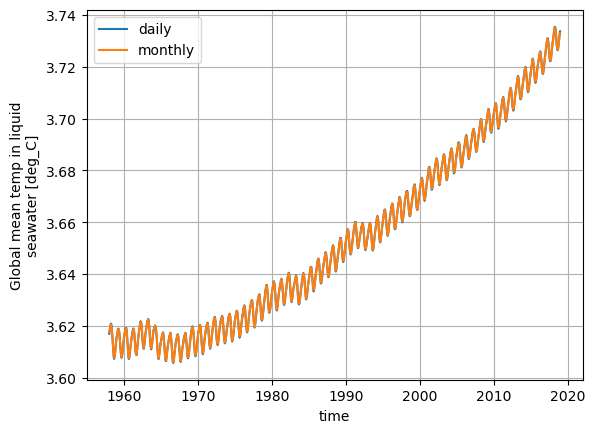

In [18]:
import matplotlib.pyplot as plt

dataset_dict["ocean_scalar_snapshot.1day"]["temp_global_ave"].plot(label="daily")
dataset_dict["ocean_scalar.1mon"]["temp_global_ave"].plot(label="monthly")

plt.title("")
plt.legend()
plt.grid()

Note, when there is only one dataset in an Intake-ESM datastore, it can be opened into an xarray Dataset using the `to_dask` method. For example, below we filter our datastore further to only include the monthly dataset and then open this using `to_dask`.

In [19]:
dataset = esm_datastore_filtered.search(frequency="1mon").to_dask(progressbar=False)

dataset

<xarray.Dataset> Size: 79kB
Dimensions:                (scalar_axis: 1, time: 732, nv: 2)
Coordinates:
  * scalar_axis            (scalar_axis) float64 8B 0.0
  * time                   (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... ...
  * nv                     (nv) float64 16B 1.0 2.0
Data variables: (12/19)
    total_mass_seawater    (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_volume_seawater  (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_adjust             (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    pbot_adjust            (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    rhoave                 (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    eta_global             (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...                     ...
    total_ocean_heat       (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_net_sfc_heating  (time, scalar_axis) float32 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    average_T1             (time) datetime64[ns] 6kB dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2             (time) datetime64[ns] 6kB dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT             (time) timedelta64[ns] 6kB dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds            (time, nv) timedelta64[ns] 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_scalar.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['total_mass_seawater', 'total_...
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          kg,m^3,m,dbar,kg/m^3,meter,deg_...
    intake_esm_attrs:filename:                ocean_scalar.nc
    intake_esm_attrs:file_id:                 ocean_scalar
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_scalar.1mon

## Passing a catalog query on to an Intake-ESM datastore

A common workflow when using the ACCESS-NRI catalog is to execute the same search on the ACCESS-NRI catalog and the resulting Intake-ESM datastores. For example, we might want to search for products containing a particular variable in the ACCESS-NRI catalog and then open datasets containing that variable from the resulting product datastore(s). To avoid code duplication in this case, the catalog `to_source` and `to_source_dict` methods accept an argument `pass_query` which if `True` tries to pass the most recent query on the ACCESS-NRI catalog on to the datastore(s).

For example, let's search for all ACCESS-OM2 products with the variable `temp_global_ave` at monthly frequency and get the datastores for all the resulting products. Each datastore in `esm_datastore_dict` comprises multiple datasets, most of which don't include the variable we're interested in.

In [20]:
catalog_filtered2 = catalog.search(model="ACCESS-OM2", frequency="1mon", variable="temp_global_ave")

esm_datastore_dict = catalog_filtered2.to_source_dict()

esm_datastore_dict

{'1deg_jra55_iaf_omip2spunup_cycle26': <1deg_jra55_iaf_omip2spunup_cycle26 catalog with 4 dataset(s) from 915 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle2': <1deg_jra55_iaf_omip2spunup_cycle2 catalog with 11 dataset(s) from 2013 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle42': <1deg_jra55_iaf_omip2spunup_cycle42 catalog with 4 dataset(s) from 915 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle17': <1deg_jra55_iaf_omip2spunup_cycle17 catalog with 4 dataset(s) from 915 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 11 dataset(s) from 2013 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 11 dataset(s) from 2013 asset(s)>,
 '025deg_jra55_ryf9091_gadi': <025deg_jra55_ryf9091_gadi catalog with 6 dataset(s) from 8951 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle45': <1deg_jra55_iaf_omip2spunup_cycle45 catalog with 4 dataset(s) from 915 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog 

So to load the data we want we need to execute essentially the same search again (now on each of the datastores) to filter for only the datasets containing `temp_global_ave` at monthly frequency.

In [21]:
esm_datastore_dict_filtered = {
    name: datastore.search(frequency="1mon", variable="temp_global_ave")
    for name, datastore in esm_datastore_dict.items()
}

esm_datastore_dict_filtered

{'1deg_jra55_iaf_omip2spunup_cycle26': <1deg_jra55_iaf_omip2spunup_cycle26 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle2': <1deg_jra55_iaf_omip2spunup_cycle2 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle42': <1deg_jra55_iaf_omip2spunup_cycle42 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle17': <1deg_jra55_iaf_omip2spunup_cycle17 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_ryf9091_gadi': <025deg_jra55_ryf9091_gadi catalog with 1 dataset(s) from 325 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle45': <1deg_jra55_iaf_omip2spunup_cycle45 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset

To avoid this sort of code duplication, we could instead use the `pass_query` argument when we call `to_source_dict` to pass the catalog query on to the `search` method of Intake-ESM datastores.

In [22]:
esm_datastore_dict2 = catalog_filtered2.to_source_dict(pass_query=True)

esm_datastore_dict2

{'1deg_jra55_iaf_omip2spunup_cycle26': <1deg_jra55_iaf_omip2spunup_cycle26 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle2': <1deg_jra55_iaf_omip2spunup_cycle2 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle42': <1deg_jra55_iaf_omip2spunup_cycle42 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle17': <1deg_jra55_iaf_omip2spunup_cycle17 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_ryf9091_gadi': <025deg_jra55_ryf9091_gadi catalog with 1 dataset(s) from 325 asset(s)>,
 '1deg_jra55_iaf_omip2spunup_cycle45': <1deg_jra55_iaf_omip2spunup_cycle45 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset

```{note}
If we hadn't suppressed warnings at the start of this notebook, we'd see a bunch of warnings from the previous cell telling us that the query on model was not passed on because there is no column "model" in the Intake-ESM datastores. The other queries on "variable" and "frequency" were passed on successfully so we're left with only one dataset in each datastore.
```

Now that we have our appropriately filtered datastores, we can easily open and plot the data. There's data from 60 different ACCESS-OM2 model runs in the following plot.

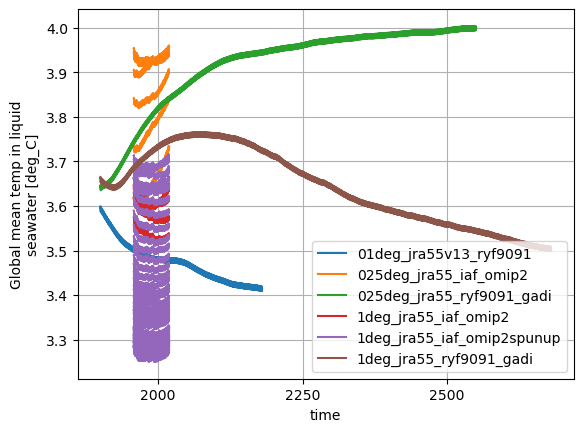

In [23]:
colors = {
    "01deg_jra55v13_ryf9091": "C0",
    "025deg_jra55_iaf_omip2": "C1",
    "025deg_jra55_ryf9091_gadi": "C2",
    "1deg_jra55_iaf_omip2": "C3",
    "1deg_jra55_iaf_omip2spunup": "C4",
    "1deg_jra55_ryf9091_gadi": "C5",
}

for idx, name in enumerate(sorted(esm_datastore_dict2.keys())):
    label = name.split("_cycle")[0]
    data = esm_datastore_dict2[name].to_dask(
        progressbar=False, xarray_open_kwargs=dict(use_cftime=True),
    )
    data["temp_global_ave"].plot(color=colors[label], label=label) 

plt.title("")
plt.grid()

# Remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

## A multi-model example

As another simple example, let's use the ACCESS-NRI catalog to carry out an analysis comparing the SST climatology in the Nino-3.4 region from three data products:

- An ACCESS-OM2 experiment: `1deg_jra55_iaf_omip2_cycle1`
- An ACCESS-ESM1.5 experiment: `HI_C_05_r1`
- An ACCESS-CM2 experiment: `bx944`

First we'll search directly for the products by their names and get the Intake-ESM datastores for those experiments. Here we use the `to_source_dict` method to load the datastores because there is more than one of them.

In [24]:
esm_datastore_dict3 = catalog.search(
    name=[
        "1deg_jra55_iaf_omip2_cycle1",
        "HI_C_05_r1",
        "bx944"
    ]
).to_source_dict()

Now we'll search on monthly SST within each datastore and open each monthly SST dataset as an xarray Dataset (here we use the `to_dask` method because there is only one dataset remaining in the Intake-ESM datastore after the search is applied). We also rename the `xt_ocean` and `yt_ocean` to `longitude` and `latitude` which isn't correct globally, but `xt_ocean` and `yt_ocean` can be interpretted as longitudes and latitudes in the region we're interested in. The renaming is done simply to make things a little more convenient later on.

In [25]:
# Some useful keyword arguments to make opening with xarray faster
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)
xarray_open_kwargs = dict(
    use_cftime=True,
)
    
dataset_dict = {
    name: datastore.search(
        realm="ocean",
        variable="sst",
        frequency="1mon"
    ).to_dask(
        xarray_open_kwargs=xarray_open_kwargs, 
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    ).rename({"xt_ocean": "longitude", "yt_ocean": "latitude"})
    for name, datastore in esm_datastore_dict3.items()
}

Now we can do our analysis on these data. To do this, we use two functions: the first computes the monthly climatological mean in the Nino-3.4 region over 1971-2000; and the second wraps the first to compute and plot the climatological mean for a dictionary of datasets containing the variable `sst`.

In [26]:
def compute_nino34_clim(sst):
    """
    Compute the monthly climatological mean in the Nino-3.4 region over 1971-2000
    """
    sst = sst.sel(time=slice("1971", "2000"))
    
    sst = sst.assign_coords(
        {"longitude": (sst["longitude"] + 360) % 360}
    )
    
    # NOTE: really, this should be area weighted
    sst_nino34 = sst.where(
        (sst.latitude < 5) & 
        (sst.latitude > -5) & 
        (sst.longitude > 190) & 
        (sst.longitude < 240), 
        drop=True
    ).mean(
        set(sst.latitude.dims + sst.longitude.dims)
    ).compute()
    
    return sst_nino34.groupby("time.month").mean("time")

def plot_nino34_clim(dataset_dict):
    """
    Plot the monthly climatological mean of SST in the Nino-3.4 region over 1971-2000
    """
    for idx, (name, ds) in enumerate(dataset_dict.items()):
        nino34_clim = compute_nino34_clim(ds)["sst"]
        
        # NOTE: there're better ways to deal with units, but this will do for this demo
        if (nino34_clim > 273.15).any().item():
            nino34_clim -= 273.15
            
        nino34_clim.plot.line(x="month", color=f"C{idx}", add_legend=False, label=name)

    plt.title("SST climatology in Nino-3.4 region")
    plt.ylabel("SST")
    plt.grid()

    # Remove duplicates in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

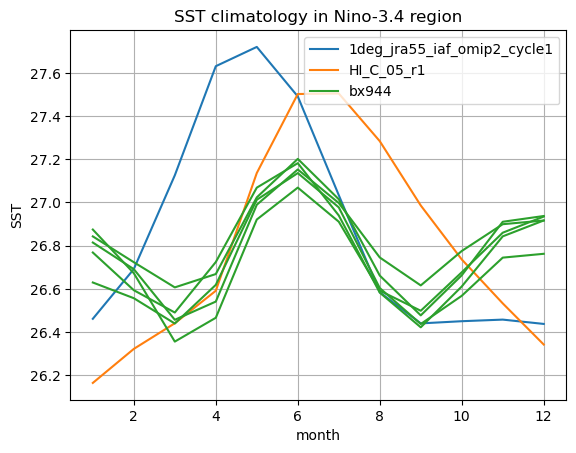

In [27]:
plot_nino34_clim(dataset_dict)

Maybe we'd also like to add some ACCESS-ESM1-5 CMIP6 data to our plot? That's easy because the [NCI CMIP6 Intake-ESM datastores](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098) are included in the ACCESS-NRI catalog.

In [28]:
cmip6_datastore = catalog.search(name="cmip6.*", model="ACCESS-ESM1-5").to_source()

Let's search for and load the ACCESS-ESM1-5 historical run. In this Intake-ESM datastore (which was generated by NCI), each of the 40 ACCESS-ESM1-5 ensemble members are considered separate datasets. We'll open them using `to_dataset_dict` and concantenate them into a single dataset.

In [29]:
cmip6_datastore_filtered = cmip6_datastore.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    file_type="f"
)

cmip6_datastore_filtered

,unique
path,40
file_type,1
realm,1
frequency,1
table_id,1
project_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,40


In [30]:
import xarray as xr

ds = xr.concat(
    cmip6_datastore_filtered.to_dataset_dict(progressbar=False).values(), 
    dim="member"
)

Now we can add the CMIP6 ACCESS-ESM1-5 ensemble to our plot. Perhaps unsurprisingly, the added climatologies look very similar to the `HI_C_05_r1` climatology (which uses the same model).

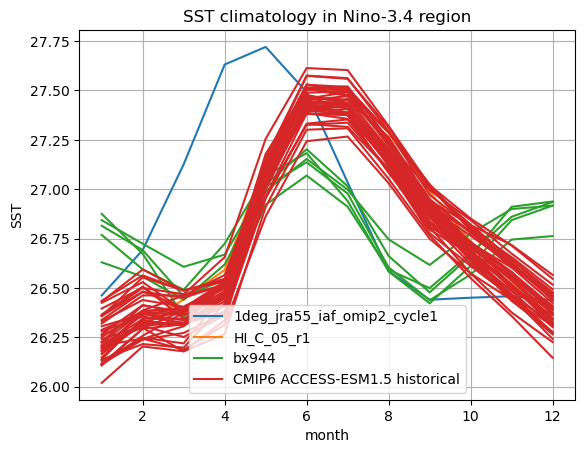

In [31]:
dataset_dict["CMIP6 ACCESS-ESM1.5 historical"] = ds.rename({"tos": "sst"})

plot_nino34_clim(dataset_dict)

In [32]:
client.close()